# ProteinB: 
## Mechanism/Pathway Distribution using Fundamental Sequences (after mfpt clustering)
This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display

## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
traj_files = [f for f in sorted(glob('../../../DESHAWTRAJS/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/PRB-0-protein-*.dcd'))]
pdb_file = '../../../DESHAWTRAJS/DESRES-Trajectory_PRB-0-protein/proteinB.pdb'

features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

13-02-18 10:34:08 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

13-02-18 10:46:20 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 25 steps.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


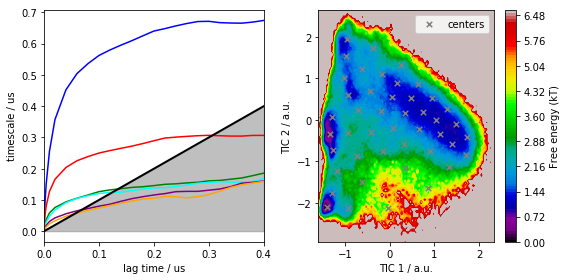

In [4]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=45, max_iter=100)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 1500 steps


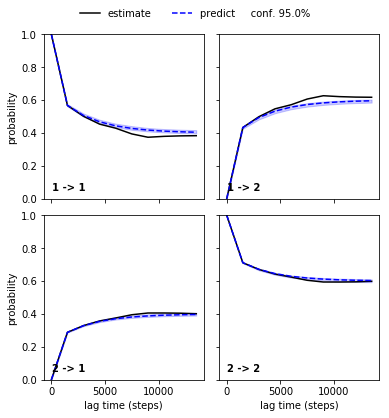

In [5]:
lag = get_lagtime_from_array(lags, 0.3, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

# RMSD

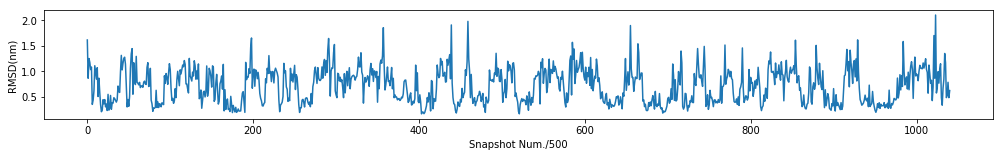

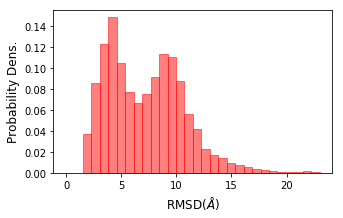

In [6]:
path='../../../DESHAWTRAJS/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/'
reference = md.load_dcd(path + 'PRB-0-protein-008.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 2 to 44')


rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference, 9600, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize=(17, 2))
plt.plot(rmsd[::500])
#plt.axis([0, 200, 0.0, 1.5])
plt.ylabel('RMSD(nm)')
plt.xlabel('Snapshot Num./500')
plt.show()

# to Angstrom
rmsd = np.array(rmsd) * 10.0

#histogram
fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color='r', alpha=0.5, edgecolor='r')
ax1.set_xlabel('RMSD$(\AA)$', fontsize=12)
ax1.set_ylabel('Probability Dens.', fontsize=12)


## Defining macrostates based on the RSMD (Folded < 5, Unfolded > 7)

In [17]:
stateA=[]
stateB=[]

states_dic={}
states_rmsd={}

for i, r in enumerate(rmsd):
    state = cluster.dtrajs[0][i]
    if (not (state in states_dic)):
        states_dic[state]=[r]
    else:
        states_dic[state].append(r)

for key,value in states_dic.items():
    states_rmsd[key]=sum(value)/len(value)
    

for s, r in states_rmsd.items():
    if r < 5:
        stateA.append(s)
    elif r > 7:
        stateB.append(s)

In [18]:
print(stateA, stateB)

[13, 22, 12, 9, 23, 31, 0, 29, 32, 14, 27, 3, 26, 18, 7] [21, 4, 38, 42, 35, 10, 33, 16, 1, 37, 15, 6, 5, 36, 24, 11, 41, 43, 28, 20, 8, 39, 44, 17, 30]


## Fundamental Sequences

### Building the model

For the calculation of the fundamental sequences the microstates inside every macrostate (A and B) are merged together. Then the sates A and B are not longer composed by multiple microstates but by a single (big) one. 

In [19]:
nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True)

In [20]:
m_p_color = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=1, coarse_macrostates=True, hist_length=100)

### Obtaining the FSs

In [21]:
mdFS, mdFSweights, tot_count_md = nm_model.empirical_weighted_FS()

nmFS, nmFSweights, _ = nm_model.weighted_FS()
mcFS, mcFSweights, _ = m_p_color.weighted_FS()



nm_model.markovian = True
msmFS, msmFSweights, _ = nm_model.weighted_FS() # lag=1

nm_model.lag_time = 10
msmFS_10, msmFSweights_10, _ = nm_model.weighted_FS() # lag=10

nm_model.lag_time = 50
msmFS_50, msmFSweights_50, _ = nm_model.weighted_FS() # lag=100

nm_model.lag_time = 1000
msmFS_1000, msmFSweights_1000, _ = nm_model.weighted_FS() # lag=1000


nm_model.lag_time

nm_model.markovian = False

### Comparing apples to apples

In [22]:
nmFSweights_temp = []
mcFSweights_temp = []

msmFSweights_temp = []
msmFSweights_temp_10 = []
msmFSweights_temp_50 = []
msmFSweights_temp_1000 = []



for i, element in enumerate(mdFS):
    
    # lag=1
    if element in nmFS:
        nmFSweights_temp.append(nmFSweights[nmFS.index(element)])
    else:
        nmFSweights_temp.append(0)
    
    if element in msmFS:
        msmFSweights_temp.append(msmFSweights[msmFS.index(element)])
    else:
        msmFSweights_temp.append(0)
    
    if element in mcFS:
        mcFSweights_temp.append(mcFSweights[mcFS.index(element)])
    else:
        mcFSweights_temp.append(0)
    
    # lag=10
    if element in msmFS_10:
        msmFSweights_temp_10.append(msmFSweights_10[msmFS_10.index(element)])
    else:
        msmFSweights_temp_10.append(0)
    
    # lag=50
    if element in msmFS_50:
        msmFSweights_temp_50.append(msmFSweights_50[msmFS_50.index(element)])
    else:
        msmFSweights_temp_50.append(0)
    
    # lag=1000
    if element in msmFS_1000:
        msmFSweights_temp_1000.append(msmFSweights_1000[msmFS_1000.index(element)])
    else:
        msmFSweights_temp_1000.append(0)


In [23]:
mdmin, mdmax = confindence_interval_cdf(mdFSweights, tot_count_md)

### Plot

#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton

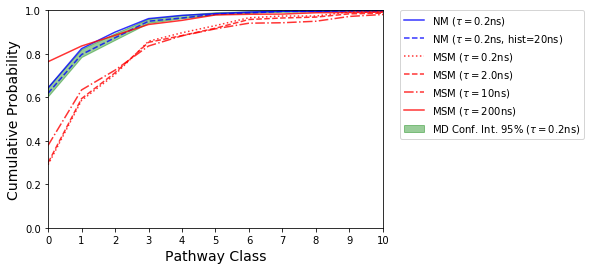

In [24]:
printmd("#### Note: We use a reduced number of states for the Fundamental Sequences. The classes are ranked based on their empirical populaiton")

alpha=0.8
x = list( range(len(mdFS))  )

plt.fill_between(x, mdmin, mdmax, color='green', alpha=0.4, label=r'MD Conf. Int. 95% ($\tau=0.2$ns)')
plt.plot(x, cdf(nmFSweights_temp), label = r'NM ($\tau=0.2$ns)', color='blue', alpha=alpha)
plt.plot(x, cdf(mcFSweights_temp), '--',label = r'NM ($\tau=0.2$ns, hist=20ns)', color='blue', alpha=alpha)

plt.plot(x, cdf(msmFSweights_temp),':', label = r'MSM ($\tau=0.2$ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_10),'--', label = r'MSM ($\tau=2.0$ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_50),'-.', label = r'MSM ($\tau=10$ns)', color='red', alpha=alpha)
plt.plot(x, cdf(msmFSweights_temp_1000),'-', label = r'MSM ($\tau=200$ns)', color='red', alpha=alpha)


plt.xticks([i for i in range(0,2*len(mdFS),1)])
plt.xlim([0,10])
plt.ylim([0,1.0])
plt.xlabel('Pathway Class', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()